# **Predicting the activity of antimicrobial peptides with machine/deep learning models**

[Sebastián Ayala Ruano](https://sayalaruano.github.io/)

This notebook is part of my capstone project for the [Machine Learning Zoomcamp](https://datatalks.club/courses/2021-winter-ml-zoomcamp.html).

[Antimicrobial peptides](https://en.wikipedia.org/wiki/Antimicrobial_peptides) (AMPs) are small bioactive drugs, commonly with fewer than 50 amino acids, which have appeared as promising compounds to control infectious disease caused by multi-drug resistant bacteria or superbugs. These superbugs are not treatable with the available drugs because of the development of some mechanisms to avoid the action of these compounds, which is known as antimicrobial resistance (AMR). According to the World Health Organization, AMR is one of the [top ten global public health threats facing humanity in this century](https://www.who.int/news-room/fact-sheets/detail/antimicrobial-resistance), so it is important to search for AMPs that combat these superbugs and prevent AMR.

However, the search for AMPs to combat superbugs by experimental methods is unfeasible because of the huge number of these compounds. So, it is required to explore other methods for handling this problem, and machine/deep learning models could be great candidates for this task. Thus, in this project I created some machine/deep learning binary classifiers to predict the activity of antimicrobial peptides.

More details about my midterm project are available in its [GitHub repository](https://github.com/sayalaruano/CapstoneProject-MLZoomCamp).

**Note:** `mkdir`, `wget`, and `unzip` are Unix based OS commands, so if you are in Windows, maybe these terminal tools won't work.

## **Installation of libraries**

### **LazyPredict**
Library to run many sklearn's binary classifiers with default parameters

In [ ]:
!pip install lazypredict

### **Pfeature**
Library to calculate molecular descriptors (features) for the AMPs

In [ ]:
# Download and unzip the files to install Pfeature
! wget https://github.com/raghavagps/Pfeature/raw/master/PyLib/Pfeature.zip
! unzip Pfeature.zip

In [ ]:
# Move to the Pfeature folder
% cd Pfeature

In [ ]:
# Run the installation script
! python setup.py install

In [ ]:
# Move to the content directory
% cd ../

### **CD-HIT**
Program to remove the redundant sequences of the AMPs

In [ ]:
# # Download and unzip the files to install CD-HIT
!wget https://github.com/weizhongli/cdhit/releases/download/V4.8.1/cd-hit-v4.8.1-2019-0228.tar.gz
!tar -xzvf cd-hit-v4.8.1-2019-0228.tar.gz

In [ ]:
# Move to the Pfeature folder
% cd cd-hit-v4.8.1-2019-0228/

In [ ]:
# Run the installation script
!make

In [9]:
# Move to the content directory
% cd ../

/content


## **Imports, data obtention and pre-processing**

In [47]:
# Data manipulation and EDA
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Features calculation
from Pfeature.pfeature import aac_wp
from Pfeature.pfeature import atc_wp
from Pfeature.pfeature import pcp_wp
from Pfeature.pfeature import rri_wp
from Pfeature.pfeature import ddr_wp
from Pfeature.pfeature import sep_wp
from Pfeature.pfeature import ser_wp
from Pfeature.pfeature import spc_wp
from Pfeature.pfeature import ctc_wp
from Pfeature.pfeature import ctd_wp

# Machine learning classifers
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

In [ ]:
# Download data 
! wget https://github.com/sayalaruano/CapstoneProject-MLZoomCamp/raw/main/Data/TR_starPep_active_AMPs.fasta
! wget https://github.com/sayalaruano/CapstoneProject-MLZoomCamp/raw/main/Data/TR_starPep_nonactive_AMPs.fasta

In [ ]:
# Print the content of one of the files
!cat TR_starPep_active_AMPs.fasta

### **Remove redundant sequences using CD-HIT**

In [ ]:
# Active AMPs
!cd-hit-v4.8.1-2019-0228/cd-hit -i TR_starPep_active_AMPs.fasta -o TR_starPep_active_AMPs.txt -c 0.99

In [ ]:
# Non-active AMPs
!cd-hit-v4.8.1-2019-0228/cd-hit -i TR_starPep_nonactive_AMPs.fasta -o TR_starPep_nonactive_AMPs.txt -c 0.99

In [13]:
# Number of active AMPs (before processing)
! grep -c ">" TR_starPep_active_AMPs.fasta

9781


In [14]:
# Number of non-redundant and active AMPs (after processing)
! grep -c ">" TR_starPep_active_AMPs.txt

6943


In [15]:
# Number of non-active AMPs (before processing)
! grep -c ">" TR_starPep_nonactive_AMPs.fasta

9767


In [16]:
# Number of non-redundant and non-active AMPs (after processing)
!grep -c ">" TR_starPep_nonactive_AMPs.txt

7666


## **Feature matrices preparation**

For this work, we will consider ten features that require only inputfile and outputfile as parameters. These features are summarized in the table below.

Feature claass | Description | Function
---|---|---
AAC | Amino acid composition | aac_wp
ABC | Atom and bond composition | atc_wp, btc_wp
PCP | Physico-chemical properties | pcp_wp
RRI | Repetitive Residue Information | rri_wp
DDR | Distance distribution of residues |ddr_wp
SEP | Shannon entropy | sep_wp
SER | Shannon entropy of residue level | ser_wp
SPC | Shannon entropy of physicochemical property | spc_wp
CTC | Conjoint Triad Calculation | ctc_wp
CTD | Composition enhanced transition distribution | ctd_wp

To know the details of these features, you can read the [Pfeature Manual](https://webs.iiitd.edu.in/raghava/pfeature/Pfeature_Manual.pdf)

### **Calculation of molecular descriptors (features) with Pfeature**
You can run this section by yourself, but due to the size of the dataset it can take a while, so I recommend you to use output files provided [here](https://github.com/sayalaruano/CapstoneProject-MLZoomCamp/raw/main/Data/PF_features.zip), and move to the next section to load this data.

In [ ]:
# Create a list with names of functions to obtain the features
PF_list = [aac_wp,
           atc_wp,
           pcp_wp,
           rri_wp,
           ddr_wp,
           sep_wp,
           ser_wp, 
           spc_wp,
           ctc_wp, 
           ctd_wp]

#### **Function for calculating the different features**

In [ ]:
def PF_feature_calc(input, feature):
  temp = input.rstrip('txt')
  output = temp + feature.__name__ + '.csv'
  df_out = feature(input, output)
  df_in = pd.read_csv(output)
  return df_in

#### **Function to create feature matrices**

This function calculates features for both positive and negative classes, combines the two classes, and merges the results into a single dataframe.

In [ ]:
# Create a directory to store the cv files of the fature matrices
!mkdir PF_features

In [ ]:
# Define variables with names of the active and non-active AMPs files
pos = 'TR_starPep_active_AMPs.txt'
neg = 'TR_starPep_nonactive_AMPs.txt'

def act_non_act_concat(po, ne, feature_name):
  # Calculate feature
  po_feature = PF_feature_calc(po, feature_name)
  ne_feature = PF_feature_calc(ne, feature_name)
  # Create class labels
  po_class = pd.Series(['positive' for i in range(len(po_feature))])
  ne_class = pd.Series(['negative' for i in range(len(ne_feature))])
  # Combine po and ne
  po_ne_class = pd.concat([po_class, ne_class], axis=0)
  po_ne_class.name = 'class'
  po_ne_feature = pd.concat([po_feature, ne_feature], axis=0)
  # Combine feature and class
  df = pd.concat([po_ne_feature, po_ne_class], axis=1)
  # Export th csv file of the feature matrix
  out_name = feature_name.__name__ + ".csv"
  df.to_csv("PF_features/" + out_name)
  return df

In [ ]:
# Define a dictionary to store all feature matrices
PF_features_dfs = {}

# Loop to create feature matrices with all features
for i in PF_list: 
  temp = act_non_act_concat(pos, neg, i)
  PF_features_dfs[i.__name__] = temp

In [ ]:
!mkdir PF_features

### **Load molecular descriptors (features)**

In [ ]:
# Download and unzip calculated molecular descriptor files
#! mkdir PF_features
#! wget https://github.com/sayalaruano/CapstoneProject-MLZoomCamp/raw/main/Data/PF_features.zip --directory PF_features
! unzip PF_features/PF_features.zip -d PF_features

In [19]:
# Create a list with names of the feature's files
PF_files_list = [
           "aac_wp",
           "atc_wp",
           "pcp_wp",
           "rri_wp",
           "ddr_wp",
           "sep_wp",
           "ser_wp", 
           "spc_wp",
           "ctc_wp", 
           "ctd_wp"]

In [20]:
# Load target variable 
temp = pd.read_csv("PF_features/aac_wp.csv", index_col=0)

y = temp['class'].copy()

# Encoding the target class label
y = y.map({"positive": 1, "negative": 0})

In [21]:
# Load original molecular descriptor files and storage them in a dictionary
PF_features_dfs = {}

for i in PF_files_list:
  path = "PF_features/"
  feature_file_path = ''.join([path,i])
  
  feature_name_csv = ''.join([feature_file_path,'.csv'])
  print(feature_name_csv)
  
  PF_features_dfs[str(i)] = pd.read_csv(feature_name_csv, index_col=0)
  PF_features_dfs[str(i)] = PF_features_dfs[str(i)] .drop('class', axis=1)

PF_features/aac_wp.csv
PF_features/atc_wp.csv
PF_features/pcp_wp.csv
PF_features/rri_wp.csv
PF_features/ddr_wp.csv
PF_features/sep_wp.csv
PF_features/ser_wp.csv
PF_features/spc_wp.csv
PF_features/ctc_wp.csv
PF_features/ctd_wp.csv


## **Exploratory Data Analysis**

### **Target variable**

In [ ]:
# Search missing values 
PF_features_dfs["aac_wp"]["class"].isnull().sum()

0

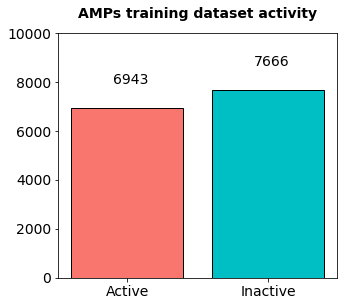

In [ ]:
# Bar plot of active and inactive AMPs

# Data
active = (PF_features_dfs["aac_wp"]["class"] == "positive").sum()
inactive = (PF_features_dfs["aac_wp"]["class"] == "negative").sum()

x = ['Active', 'Inactive']
y = [active, inactive]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('AMPs training dataset activity', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

ax.set_ylim(0,10000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

The previous plot shows that this dataset is balanced regarding their classes

### **Amino acid composition  feature matrix**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["aac_wp"]

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y,class
0,0.00,0.00,7.69,0.00,15.38,15.38,0.00,23.08,7.69,15.38,0.00,7.69,0.00,0.00,0.00,7.69,0.00,0.00,0.0,0.00,positive
1,15.38,0.00,0.00,0.00,7.69,7.69,0.00,15.38,0.00,30.77,0.00,7.69,0.00,0.00,0.00,15.38,0.00,0.00,0.0,0.00,positive
2,15.38,0.00,0.00,0.00,15.38,7.69,0.00,0.00,15.38,38.46,0.00,0.00,0.00,0.00,0.00,7.69,0.00,0.00,0.0,0.00,positive
3,0.00,0.00,0.00,5.88,0.00,0.00,5.88,5.88,0.00,29.41,0.00,11.76,11.76,11.76,0.00,0.00,5.88,5.88,0.0,5.88,positive
4,0.00,0.00,7.69,0.00,7.69,7.69,0.00,7.69,0.00,23.08,0.00,0.00,7.69,7.69,7.69,0.00,15.38,7.69,0.0,0.00,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,7.78,5.56,10.00,8.89,4.44,4.44,1.11,10.00,6.67,12.22,2.22,3.33,1.11,3.33,2.22,8.89,2.22,4.44,0.0,1.11,negative
7662,0.00,0.00,0.00,0.00,10.53,21.05,5.26,0.00,5.26,10.53,5.26,10.53,5.26,0.00,0.00,5.26,15.79,5.26,0.0,0.00,negative
7663,0.00,10.00,0.00,5.00,5.00,10.00,5.00,0.00,10.00,5.00,5.00,20.00,0.00,0.00,0.00,0.00,15.00,5.00,0.0,5.00,negative
7664,6.06,6.06,4.55,9.09,3.03,1.52,3.03,6.06,9.09,4.55,7.58,4.55,1.52,6.06,4.55,9.09,3.03,6.06,0.0,4.55,negative


In [ ]:
# General measurements of the feature matrix 
PF_features_dfs["aac_wp"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 7665
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAC_A   14609 non-null  float64
 1   AAC_C   14609 non-null  float64
 2   AAC_D   14609 non-null  float64
 3   AAC_E   14609 non-null  float64
 4   AAC_F   14609 non-null  float64
 5   AAC_G   14609 non-null  float64
 6   AAC_H   14609 non-null  float64
 7   AAC_I   14609 non-null  float64
 8   AAC_K   14609 non-null  float64
 9   AAC_L   14609 non-null  float64
 10  AAC_M   14609 non-null  float64
 11  AAC_N   14609 non-null  float64
 12  AAC_P   14609 non-null  float64
 13  AAC_Q   14609 non-null  float64
 14  AAC_R   14609 non-null  float64
 15  AAC_S   14609 non-null  float64
 16  AAC_T   14609 non-null  float64
 17  AAC_V   14609 non-null  float64
 18  AAC_W   14609 non-null  float64
 19  AAC_Y   14609 non-null  float64
 20  class   14609 non-null  object 
dtypes: float64(20), object(1)
memory usa

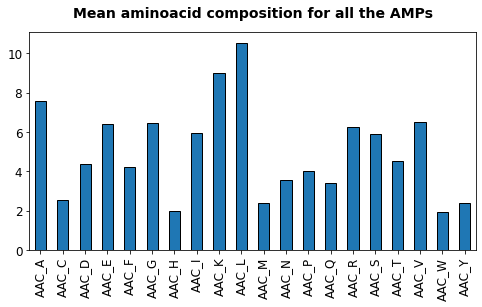

In [ ]:
# General statistics of the feature matrix for all AMPs
feat_stat = PF_features_dfs["aac_wp"].describe().T

# Bar plot of mean aminoacid composition for all the AMPs
mean_values = feat_stat["mean"]

mean_values.plot.bar(figsize=(8,4), ec='black')

plt.title('Mean aminoacid composition for all the AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

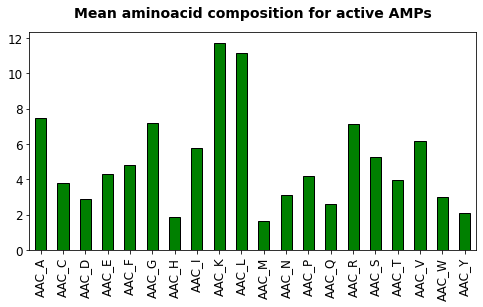

In [ ]:
# General statistics of the feature matrix for active AMPs
feat_stat_act = PF_features_dfs["aac_wp"][PF_features_dfs["aac_wp"]["class"] 
                                          == "positive"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_act = feat_stat_act["mean"]

mean_values_act.plot.bar(figsize=(8,4), color = 'green', ec='black')

plt.title('Mean aminoacid composition for active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

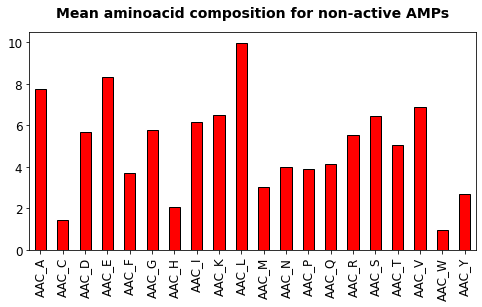

In [ ]:
# General statistics of the feature matrix for non-active AMPs
feat_stat_nact = PF_features_dfs["aac_wp"][PF_features_dfs["aac_wp"]["class"] 
                                          == "negative"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_nact = feat_stat_nact["mean"]

mean_values_nact.plot.bar(figsize=(8,4), color = 'red', ec='black')

plt.title('Mean aminoacid composition for non-active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We observed that the distribution of the mean aminoacid composition from active and non-active AMPs is different.

### **Atom and bond composition**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["atc_wp"]

,ATC_C,ATC_H,ATC_N,ATC_O,ATC_S,class
0,27.94,12.15,53.85,6.07,0.00,positive
1,26.69,12.29,55.08,5.93,0.00,positive
2,27.95,10.63,55.51,5.91,0.00,positive
3,27.35,12.35,53.53,6.76,0.00,positive
4,26.88,12.25,54.15,6.72,0.00,positive
...,...,...,...,...,...,...
7661,26.08,13.92,52.95,6.63,0.42,negative
7662,26.75,13.37,52.28,7.29,0.30,negative
7663,26.17,13.77,51.52,7.71,0.83,negative
7664,26.13,13.34,52.50,7.31,0.71,negative


In [ ]:
# General measurements of the feature matrix 
PF_features_dfs["atc_wp"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 7665
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ATC_C   14609 non-null  float64
 1   ATC_H   14609 non-null  float64
 2   ATC_N   14609 non-null  float64
 3   ATC_O   14609 non-null  float64
 4   ATC_S   14609 non-null  float64
 5   class   14609 non-null  object 
dtypes: float64(5), object(1)
memory usage: 798.9+ KB


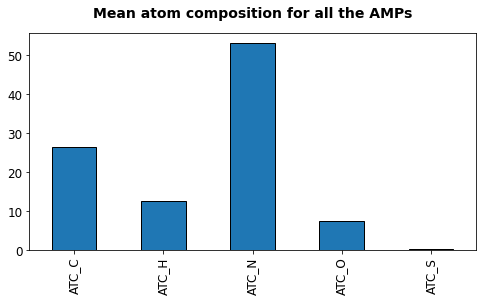

In [ ]:
# General statistics of the feature matrix for all AMPs
feat_stat = PF_features_dfs["atc_wp"].describe().T

# Bar plot of mean aminoacid composition for all the AMPs
mean_values = feat_stat["mean"]

mean_values.plot.bar(figsize=(8,4), ec='black')

plt.title('Mean atom composition for all the AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

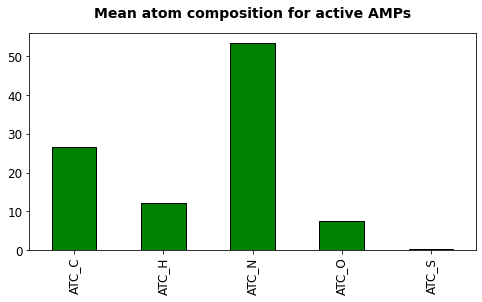

In [ ]:
# General statistics of the feature matrix for active AMPs
feat_stat_act = PF_features_dfs["atc_wp"][PF_features_dfs["atc_wp"]["class"] 
                                          == "positive"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_act = feat_stat_act["mean"]

mean_values_act.plot.bar(figsize=(8,4), color = 'green', ec='black')

plt.title('Mean atom composition for active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

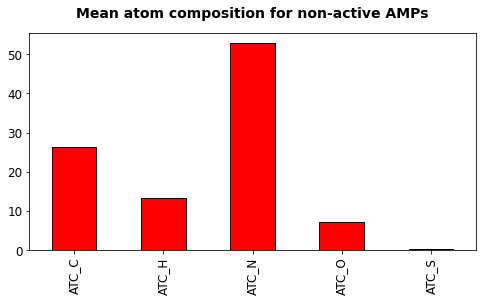

In [ ]:
# General statistics of the feature matrix for non-active AMPs
feat_stat_nact = PF_features_dfs["atc_wp"][PF_features_dfs["atc_wp"]["class"] 
                                          == "negative"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_nact = feat_stat_nact["mean"]

mean_values_nact.plot.bar(figsize=(8,4), color = 'red', ec='black')

plt.title('Mean atom composition for non-active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

There are not apparent differences in the distribution of mean atom composition from active and non-active AMPs

### **Physico-chemical properties**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["pcp_wp"]

,PCP_PC,PCP_NC,PCP_NE,PCP_PO,PCP_NP,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_NT,PCP_HX,PCP_SC,PCP_SS_HE,PCP_SS_ST,PCP_SS_CO,PCP_SA_BU,PCP_SA_EX,PCP_SA_IN,PCP_TN,PCP_SM,PCP_LR,PCP_Z1,PCP_Z2,PCP_Z3,PCP_Z4,PCP_Z5,class
0,0.077,0.077,0.846,0.077,0.692,0.538,0.000,0.154,0.077,0.077,0.846,0.538,0.154,0.308,0.077,0.000,0.231,0.385,0.385,0.692,0.231,0.077,0.231,0.385,0.615,-0.989,-0.743,-0.280,-0.618,0.045,positive
1,0.000,0.000,1.000,0.154,0.769,0.692,0.000,0.077,0.000,0.000,1.000,0.692,0.077,0.231,0.154,0.000,0.462,0.231,0.308,0.769,0.077,0.154,0.385,0.462,0.538,-1.443,-1.226,-0.263,-0.696,0.401,positive
2,0.154,0.000,0.846,0.077,0.769,0.615,0.000,0.154,0.000,0.154,0.846,0.692,0.154,0.154,0.077,0.000,0.692,0.154,0.154,0.769,0.154,0.077,0.308,0.308,0.692,-1.565,-0.816,-0.585,-0.156,0.498,positive
3,0.059,0.059,0.882,0.235,0.529,0.529,0.118,0.059,0.059,0.059,0.882,0.588,0.294,0.235,0.059,0.000,0.529,0.235,0.235,0.412,0.412,0.294,0.000,0.353,0.647,-1.048,-0.213,-0.492,-0.555,0.265,positive
4,0.077,0.077,0.846,0.231,0.615,0.538,0.077,0.077,0.077,0.077,0.846,0.692,0.154,0.385,0.154,0.000,0.385,0.385,0.231,0.538,0.231,0.231,0.077,0.462,0.538,-0.954,-0.812,-0.747,-0.628,0.323,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,0.100,0.189,0.711,0.211,0.467,0.400,0.011,0.056,0.189,0.100,0.711,0.500,0.144,0.378,0.111,0.078,0.444,0.278,0.278,0.489,0.333,0.167,0.267,0.478,0.522,0.154,-0.612,-0.064,-0.740,0.111,negative
7662,0.105,0.000,0.895,0.211,0.579,0.421,0.053,0.105,0.000,0.105,0.895,0.526,0.263,0.421,0.211,0.053,0.263,0.316,0.421,0.474,0.211,0.368,0.263,0.632,0.368,-0.021,-1.004,-0.053,-0.238,-0.181,negative
7663,0.150,0.050,0.800,0.300,0.300,0.200,0.000,0.100,0.050,0.150,0.800,0.450,0.350,0.300,0.150,0.150,0.300,0.400,0.300,0.350,0.350,0.300,0.200,0.600,0.400,0.696,-0.365,0.152,-0.274,-0.774,negative
7664,0.167,0.136,0.697,0.288,0.364,0.258,0.015,0.076,0.136,0.167,0.697,0.439,0.227,0.333,0.121,0.136,0.500,0.288,0.212,0.333,0.348,0.288,0.227,0.424,0.576,0.416,-0.210,-0.152,-0.318,-0.114,negative


In [ ]:
# General measurements of the feature matrix 
PF_features_dfs["pcp_wp"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 7665
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PCP_PC     14609 non-null  float64
 1   PCP_NC     14609 non-null  float64
 2   PCP_NE     14609 non-null  float64
 3   PCP_PO     14609 non-null  float64
 4   PCP_NP     14609 non-null  float64
 5   PCP_AL     14609 non-null  float64
 6   PCP_CY     14609 non-null  float64
 7   PCP_AR     14609 non-null  float64
 8   PCP_AC     14609 non-null  float64
 9   PCP_BS     14609 non-null  float64
 10  PCP_NE_pH  14609 non-null  float64
 11  PCP_HB     14609 non-null  float64
 12  PCP_HL     14609 non-null  float64
 13  PCP_NT     14609 non-null  float64
 14  PCP_HX     14609 non-null  float64
 15  PCP_SC     14609 non-null  float64
 16  PCP_SS_HE  14609 non-null  float64
 17  PCP_SS_ST  14609 non-null  float64
 18  PCP_SS_CO  14609 non-null  float64
 19  PCP_SA_BU  14609 non-null  float64
 20  PCP_SA_

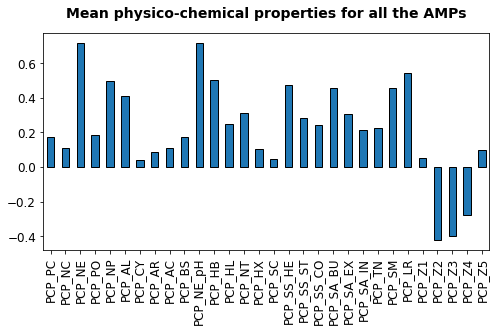

In [ ]:
# General statistics of the feature matrix for all AMPs
feat_stat = PF_features_dfs["pcp_wp"].describe().T

# Bar plot of mean aminoacid composition for all the AMPs
mean_values = feat_stat["mean"]

mean_values.plot.bar(figsize=(8,4), ec='black')

plt.title('Mean physico-chemical properties for all the AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

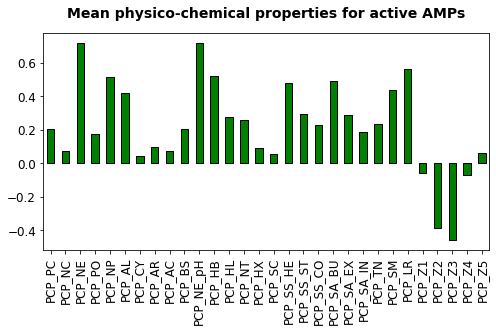

In [ ]:
# General statistics of the feature matrix for active AMPs
feat_stat_act = PF_features_dfs["pcp_wp"][PF_features_dfs["pcp_wp"]["class"] 
                                          == "positive"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_act = feat_stat_act["mean"]

mean_values_act.plot.bar(figsize=(8,4), color = 'green', ec='black')

plt.title('Mean physico-chemical properties for active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

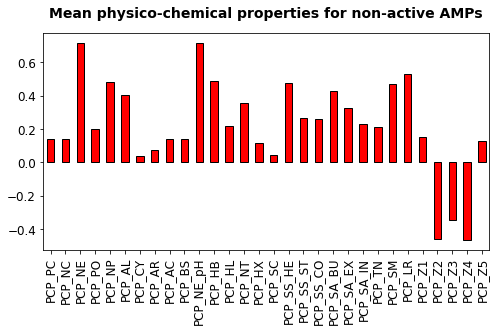

In [ ]:
# General statistics of the feature matrix for non-active AMPs
feat_stat_nact = PF_features_dfs["pcp_wp"][PF_features_dfs["pcp_wp"]["class"] 
                                          == "negative"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_nact = feat_stat_nact["mean"]

mean_values_nact.plot.bar(figsize=(8,4), color = 'red', ec='black')

plt.title('Mean physico-chemical properties for non-active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

There are not apparent differences in the distribution of mean physocochemical properties from active and non-active AMPs

### **Repetitive Residue Information**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["rri_wp"]

,RRI_A,RRI_C,RRI_D,RRI_E,RRI_F,RRI_G,RRI_H,RRI_I,RRI_K,RRI_L,RRI_M,RRI_N,RRI_P,RRI_Q,RRI_R,RRI_S,RRI_T,RRI_V,RRI_W,RRI_Y,class
0,0.0,0.0,1.0,0.00,1.0,1.0,0.0,1.50,1.00,1.00,0.00,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,positive
1,1.0,0.0,0.0,0.00,1.0,1.0,0.0,1.00,0.00,1.67,0.00,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,positive
2,1.0,0.0,0.0,0.00,1.0,1.0,0.0,0.00,1.00,1.33,0.00,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,positive
3,0.0,0.0,0.0,1.00,0.0,0.0,1.0,1.00,0.00,2.11,0.00,1.00,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,positive
4,0.0,0.0,1.0,0.00,1.0,1.0,0.0,1.00,0.00,1.50,0.00,0.00,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,1.0,1.0,1.2,1.22,1.0,1.0,1.0,1.36,1.00,1.31,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,negative
7662,0.0,0.0,0.0,0.00,1.0,1.0,1.0,0.00,1.00,1.00,1.00,1.00,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,negative
7663,0.0,1.0,0.0,1.00,1.0,1.0,1.0,0.00,1.00,1.00,1.00,2.14,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,negative
7664,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.00,1.29,1.00,1.33,1.00,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.5,negative


In [ ]:
# General measurements of the feature matrix 
PF_features_dfs["rri_wp"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 7665
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RRI_A   14609 non-null  float64
 1   RRI_C   14609 non-null  float64
 2   RRI_D   14609 non-null  float64
 3   RRI_E   14609 non-null  float64
 4   RRI_F   14609 non-null  float64
 5   RRI_G   14609 non-null  float64
 6   RRI_H   14609 non-null  float64
 7   RRI_I   14609 non-null  float64
 8   RRI_K   14609 non-null  float64
 9   RRI_L   14609 non-null  float64
 10  RRI_M   14609 non-null  float64
 11  RRI_N   14609 non-null  float64
 12  RRI_P   14609 non-null  float64
 13  RRI_Q   14609 non-null  float64
 14  RRI_R   14609 non-null  float64
 15  RRI_S   14609 non-null  float64
 16  RRI_T   14609 non-null  float64
 17  RRI_V   14609 non-null  float64
 18  RRI_W   14609 non-null  float64
 19  RRI_Y   14609 non-null  float64
 20  class   14609 non-null  object 
dtypes: float64(20), object(1)
memory usa

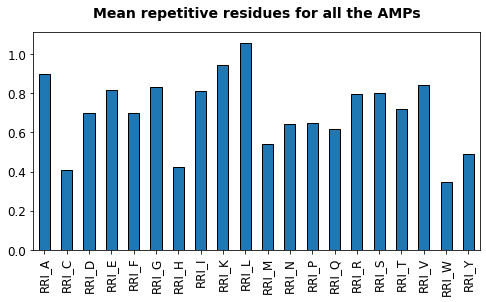

In [ ]:
# General statistics of the feature matrix for all AMPs
feat_stat = PF_features_dfs["rri_wp"].describe().T

# Bar plot of mean aminoacid composition for all the AMPs
mean_values = feat_stat["mean"]

mean_values.plot.bar(figsize=(8,4), ec='black')

plt.title('Mean repetitive residues for all the AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

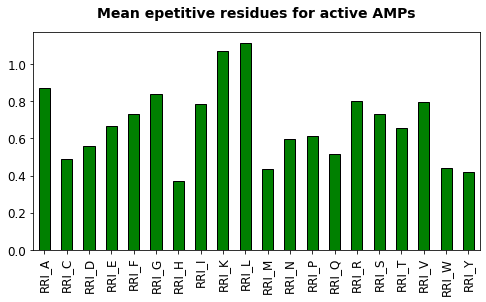

In [ ]:
# General statistics of the feature matrix for active AMPs
feat_stat_act = PF_features_dfs["rri_wp"][PF_features_dfs["rri_wp"]["class"] 
                                          == "positive"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_act = feat_stat_act["mean"]

mean_values_act.plot.bar(figsize=(8,4), color = 'green', ec='black')

plt.title('Mean epetitive residues for active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

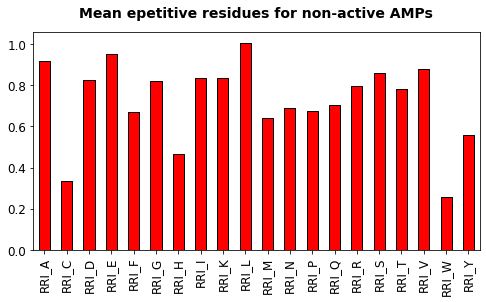

In [ ]:
# General statistics of the feature matrix for non-active AMPs
feat_stat_nact = PF_features_dfs["rri_wp"][PF_features_dfs["rri_wp"]["class"] 
                                          == "negative"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_nact = feat_stat_nact["mean"]

mean_values_nact.plot.bar(figsize=(8,4), color = 'red', ec='black')

plt.title('Mean epetitive residues for non-active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We observed that the distribution of the mean repetitive residue information from active and non-active AMPs is different.

### **Distance distribution of residues**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["ddr_wp"]

,DDR_A,DDR_C,DDR_D,DDR_E,DDR_F,DDR_G,DDR_H,DDR_I,DDR_K,DDR_L,DDR_M,DDR_N,DDR_P,DDR_Q,DDR_R,DDR_S,DDR_T,DDR_V,DDR_W,DDR_Y,class
0,0.00,0.00,6.92,0.00,4.08,8.42,0.00,3.27,5.54,8.42,0.00,5.69,0.00,0.00,0.00,8.00,0.00,0.00,0.0,0.00,positive
1,4.92,0.00,0.00,0.00,9.38,5.54,0.00,6.08,0.00,5.30,0.00,8.00,0.00,0.00,0.00,4.08,0.00,0.00,0.0,0.00,positive
2,3.58,0.00,0.00,0.00,5.42,8.00,0.00,0.00,4.08,2.00,0.00,0.00,0.00,0.00,0.00,6.92,0.00,0.00,0.0,0.00,positive
3,0.00,0.00,0.00,9.41,0.00,0.00,8.59,10.47,0.00,6.92,0.00,5.81,6.69,5.56,0.00,0.00,8.00,15.06,0.0,11.76,positive
4,0.00,0.00,8.00,0.00,8.00,5.54,0.00,6.92,0.00,4.18,0.00,0.00,9.38,6.15,11.08,0.00,5.08,5.69,0.0,0.00,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,16.04,24.31,16.67,13.81,21.70,19.66,48.06,16.35,22.75,11.29,31.26,39.26,55.26,32.03,34.76,19.04,48.88,36.25,0.0,84.14,negative
7662,0.00,0.00,0.00,0.00,8.17,6.81,9.47,0.00,8.63,9.39,11.16,6.39,9.47,0.00,0.00,8.95,6.00,8.63,0.0,0.00,negative
7663,0.00,10.84,0.00,16.25,10.25,13.68,18.05,0.00,7.37,14.65,12.05,5.29,0.00,0.00,0.00,0.00,5.39,13.25,0.0,9.25,negative
7664,21.08,17.17,17.05,14.43,26.00,33.29,29.45,15.65,15.28,17.23,29.02,27.64,32.38,38.95,21.83,10.62,22.31,15.27,0.0,23.14,negative


In [ ]:
# General measurements of the feature matrix 
PF_features_dfs["ddr_wp"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 7665
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAC_A   14609 non-null  float64
 1   AAC_C   14609 non-null  float64
 2   AAC_D   14609 non-null  float64
 3   AAC_E   14609 non-null  float64
 4   AAC_F   14609 non-null  float64
 5   AAC_G   14609 non-null  float64
 6   AAC_H   14609 non-null  float64
 7   AAC_I   14609 non-null  float64
 8   AAC_K   14609 non-null  float64
 9   AAC_L   14609 non-null  float64
 10  AAC_M   14609 non-null  float64
 11  AAC_N   14609 non-null  float64
 12  AAC_P   14609 non-null  float64
 13  AAC_Q   14609 non-null  float64
 14  AAC_R   14609 non-null  float64
 15  AAC_S   14609 non-null  float64
 16  AAC_T   14609 non-null  float64
 17  AAC_V   14609 non-null  float64
 18  AAC_W   14609 non-null  float64
 19  AAC_Y   14609 non-null  float64
 20  class   14609 non-null  object 
dtypes: float64(20), object(1)
memory usa

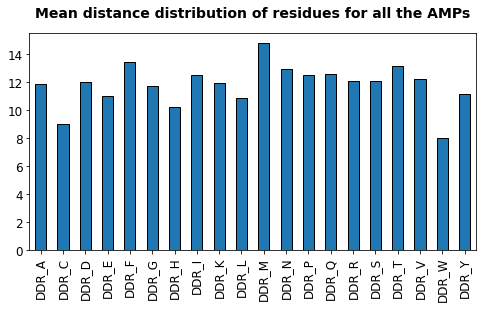

In [ ]:
# General statistics of the feature matrix for all AMPs
feat_stat = PF_features_dfs["ddr_wp"].describe().T

# Bar plot of mean aminoacid composition for all the AMPs
mean_values = feat_stat["mean"]

mean_values.plot.bar(figsize=(8,4), ec='black')

plt.title('Mean distance distribution of residues for all the AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

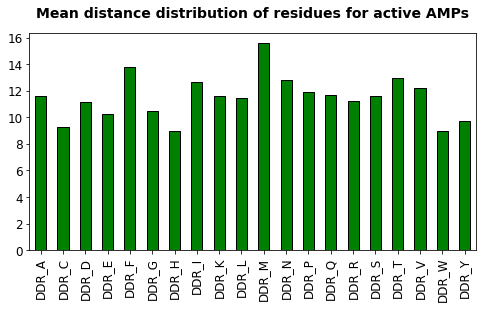

In [ ]:
# General statistics of the feature matrix for active AMPs
feat_stat_act = PF_features_dfs["ddr_wp"][PF_features_dfs["ddr_wp"]["class"] 
                                          == "positive"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_act = feat_stat_act["mean"]

mean_values_act.plot.bar(figsize=(8,4), color = 'green', ec='black')

plt.title('Mean distance distribution of residues for active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

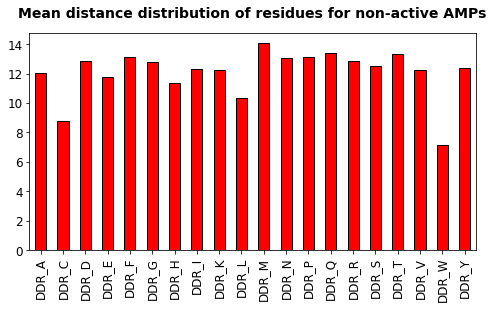

In [ ]:
# General statistics of the feature matrix for non-active AMPs
feat_stat_nact = PF_features_dfs["ddr_wp"][PF_features_dfs["ddr_wp"]["class"] 
                                          == "negative"].describe().T

# Bar plot of mean aminoacid composition for active AMPs
mean_values_nact = feat_stat_nact["mean"]

mean_values_nact.plot.bar(figsize=(8,4), color = 'red', ec='black')

plt.title('Mean distance distribution of residues for non-active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We observed that the distribution of the mean distnace distribution of residues from active and non-active AMPs is different.

### **Shannon entropy**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["sep_wp"]

,SEP,class
0,2.873,positive
1,2.624,positive
2,2.346,positive
3,3.052,positive
4,3.181,positive
...,...,...
7661,3.943,negative
7662,3.261,negative
7663,3.384,negative
7664,4.106,negative


In [ ]:
# General measurements of the feature matrix 
PF_features_dfs["sep_wp"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 7665
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SEP     14609 non-null  float64
 1   class   14609 non-null  object 
dtypes: float64(1), object(1)
memory usage: 342.4+ KB


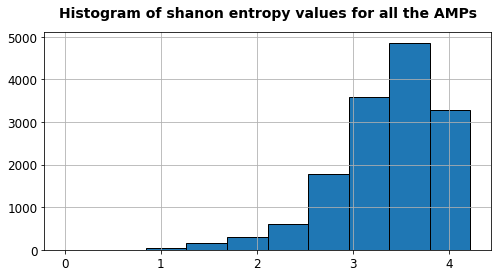

In [ ]:
# Histogram of shanon entropy for all the AMPs
SEP = PF_features_dfs["sep_wp"]["SEP"]

SEP.hist(figsize=(8,4), ec='black')

plt.title('Histogram of shanon entropy values for all the AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
PF_features_dfs["sep_wp"]["SEP"][PF_features_dfs["sep_wp"]["class"] 
                                          == "positive"]

0       2.873
1       2.624
2       2.346
3       3.052
4       3.181
        ...  
6938    2.927
6939    2.923
6940    2.953
6941    3.140
6942    2.927
Name: SEP, Length: 6943, dtype: float64

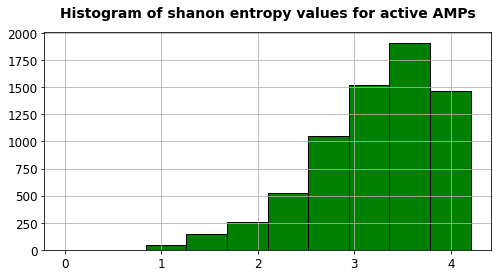

In [ ]:
# Histogram of shanon entropy for active AMPs
SEP_act = PF_features_dfs["sep_wp"]["SEP"][PF_features_dfs["sep_wp"]["class"] 
                                          == "positive"]

SEP_act.hist(figsize=(8,4),color='green', ec='black')

plt.title('Histogram of shanon entropy values for active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

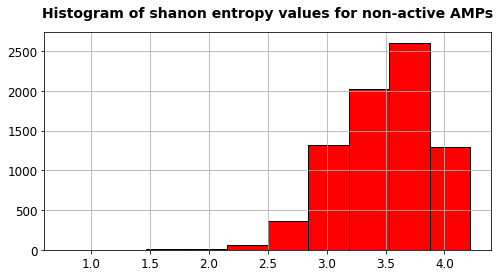

In [ ]:
# Histogram of shanon entropy for non-active AMPs
SEP_nact = PF_features_dfs["sep_wp"]["SEP"][PF_features_dfs["sep_wp"]["class"] 
                                          == "negative"]

SEP_nact.hist(figsize=(8,4),color='red', ec='black')

plt.title('Histogram of shanon entropy values for non-active AMPs', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

There are not apparent differences in the distribution of shanon entropy from active and non-active AMPs

### **Shannon entropy of residue level**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["ser_wp"]

,SER_A,SER_C,SER_D,SER_E,SER_F,SER_G,SER_H,SER_I,SER_K,SER_L,SER_M,SER_N,SER_P,SER_Q,SER_R,SER_S,SER_T,SER_V,SER_W,SER_Y,class
0,0.000,0.000,-0.285,0.000,-0.415,-0.415,0.000,-0.488,-0.285,-0.415,0.000,-0.285,0.000,0.000,0.000,-0.285,0.000,0.000,0.0,0.000,positive
1,-0.415,0.000,0.000,0.000,-0.285,-0.285,0.000,-0.415,0.000,-0.523,0.000,-0.285,0.000,0.000,0.000,-0.415,0.000,0.000,0.0,0.000,positive
2,-0.415,0.000,0.000,0.000,-0.415,-0.285,0.000,0.000,-0.415,-0.530,0.000,0.000,0.000,0.000,0.000,-0.285,0.000,0.000,0.0,0.000,positive
3,0.000,0.000,0.000,-0.240,0.000,0.000,-0.240,-0.240,0.000,-0.519,0.000,-0.363,-0.363,-0.363,0.000,0.000,-0.240,-0.240,0.0,-0.240,positive
4,0.000,0.000,-0.285,0.000,-0.285,-0.285,0.000,-0.285,0.000,-0.488,0.000,0.000,-0.285,-0.285,-0.285,0.000,-0.415,-0.285,0.0,0.000,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,-0.287,-0.232,-0.332,-0.310,-0.200,-0.200,-0.072,-0.332,-0.260,-0.371,-0.122,-0.164,-0.072,-0.164,-0.122,-0.310,-0.122,-0.200,0.0,-0.072,negative
7662,0.000,0.000,0.000,0.000,-0.342,-0.473,-0.224,0.000,-0.224,-0.342,-0.224,-0.342,-0.224,0.000,0.000,-0.224,-0.420,-0.224,0.0,0.000,negative
7663,0.000,-0.332,0.000,-0.216,-0.216,-0.332,-0.216,0.000,-0.332,-0.216,-0.216,-0.464,0.000,0.000,0.000,0.000,-0.411,-0.216,0.0,-0.216,negative
7664,-0.245,-0.245,-0.203,-0.314,-0.153,-0.092,-0.153,-0.245,-0.314,-0.203,-0.282,-0.203,-0.092,-0.245,-0.203,-0.314,-0.153,-0.245,0.0,-0.203,negative


In [ ]:
# General measurements of the feature matrix 
PF_features_dfs["ser_wp"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 7665
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SER_A   14609 non-null  float64
 1   SER_C   14609 non-null  float64
 2   SER_D   14609 non-null  float64
 3   SER_E   14609 non-null  float64
 4   SER_F   14609 non-null  float64
 5   SER_G   14609 non-null  float64
 6   SER_H   14609 non-null  float64
 7   SER_I   14609 non-null  float64
 8   SER_K   14609 non-null  float64
 9   SER_L   14609 non-null  float64
 10  SER_M   14609 non-null  float64
 11  SER_N   14609 non-null  float64
 12  SER_P   14609 non-null  float64
 13  SER_Q   14609 non-null  float64
 14  SER_R   14609 non-null  float64
 15  SER_S   14609 non-null  float64
 16  SER_T   14609 non-null  float64
 17  SER_V   14609 non-null  float64
 18  SER_W   14609 non-null  float64
 19  SER_Y   14609 non-null  float64
 20  class   14609 non-null  object 
dtypes: float64(20), object(1)
memory usa

### **Shannon entropy of physicochemical property**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["spc_wp"]

,SEP_PC,SEP_NC,SEP_NE,SEP_PO,SEP_NP,SEP_AL,SEP_CY,SEP_AR,SEP_AC,SEP_BS,SEP_NE_pH,SEP_HB,SEP_HL,SEP_NT,SEP_HX,SEP_SC,SEP_SS_HE,SEP_SS_ST,SEP_SS_CO,SEP_SA_BU,SEP_SA_EX,SEP_SA_IN,SEP_TN,SEP_SM,SEP_LR,class
0,0.391,0.391,0.619,0.391,0.890,0.996,0.000,0.619,0.391,0.391,0.619,0.996,0.619,0.890,0.391,0.000,0.779,0.961,0.961,0.890,0.779,0.391,0.779,0.961,0.961,positive
1,0.000,0.000,0.000,0.619,0.779,0.890,0.000,0.391,0.000,0.000,0.000,0.890,0.391,0.779,0.619,0.000,0.996,0.779,0.890,0.779,0.391,0.619,0.961,0.996,0.996,positive
2,0.619,0.000,0.619,0.391,0.779,0.961,0.000,0.619,0.000,0.619,0.619,0.890,0.619,0.619,0.391,0.000,0.890,0.619,0.619,0.779,0.619,0.391,0.890,0.890,0.890,positive
3,0.323,0.323,0.523,0.787,0.998,0.998,0.523,0.323,0.323,0.323,0.523,0.977,0.874,0.787,0.323,0.000,0.998,0.787,0.787,0.977,0.977,0.874,0.000,0.937,0.937,positive
4,0.391,0.391,0.619,0.779,0.961,0.996,0.391,0.391,0.391,0.391,0.619,0.890,0.619,0.961,0.619,0.000,0.961,0.961,0.779,0.996,0.779,0.779,0.391,0.996,0.996,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,0.469,0.699,0.867,0.744,0.997,0.971,0.088,0.310,0.699,0.469,0.867,1.000,0.596,0.956,0.503,0.394,0.991,0.852,0.852,1.000,0.918,0.650,0.837,0.999,0.999,negative
7662,0.485,0.000,0.485,0.742,0.982,0.982,0.297,0.485,0.000,0.485,0.485,0.998,0.831,0.982,0.742,0.297,0.831,0.900,0.982,0.998,0.742,0.949,0.831,0.949,0.949,negative
7663,0.610,0.286,0.722,0.881,0.881,0.722,0.000,0.469,0.286,0.610,0.722,0.993,0.934,0.881,0.610,0.610,0.881,0.971,0.881,0.934,0.934,0.881,0.722,0.971,0.971,negative
7664,0.650,0.575,0.885,0.866,0.946,0.823,0.113,0.387,0.575,0.650,0.885,0.989,0.773,0.918,0.533,0.575,1.000,0.866,0.746,0.918,0.933,0.866,0.773,0.983,0.983,negative


In [ ]:
# General measurements of the feature matrix 
PF_features_dfs["spc_wp"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 7665
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEP_PC     14609 non-null  float64
 1   SEP_NC     14609 non-null  float64
 2   SEP_NE     14609 non-null  float64
 3   SEP_PO     14609 non-null  float64
 4   SEP_NP     14609 non-null  float64
 5   SEP_AL     14609 non-null  float64
 6   SEP_CY     14609 non-null  float64
 7   SEP_AR     14609 non-null  float64
 8   SEP_AC     14609 non-null  float64
 9   SEP_BS     14609 non-null  float64
 10  SEP_NE_pH  14609 non-null  float64
 11  SEP_HB     14609 non-null  float64
 12  SEP_HL     14609 non-null  float64
 13  SEP_NT     14609 non-null  float64
 14  SEP_HX     14609 non-null  float64
 15  SEP_SC     14609 non-null  float64
 16  SEP_SS_HE  14609 non-null  float64
 17  SEP_SS_ST  14609 non-null  float64
 18  SEP_SS_CO  14609 non-null  float64
 19  SEP_SA_BU  14609 non-null  float64
 20  SEP_SA_

### **Conjoint Triad Calculation**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["ctc_wp"]

,CTC_111,CTC_112,CTC_113,CTC_114,CTC_115,CTC_116,CTC_117,CTC_121,CTC_122,CTC_123,CTC_124,CTC_125,CTC_126,CTC_127,CTC_131,CTC_132,CTC_133,CTC_134,CTC_135,CTC_136,CTC_137,CTC_141,CTC_142,CTC_143,CTC_144,CTC_145,CTC_146,CTC_147,CTC_151,CTC_152,CTC_153,CTC_154,CTC_155,CTC_156,CTC_157,CTC_161,CTC_162,CTC_163,CTC_164,CTC_165,...,CTC_724,CTC_725,CTC_726,CTC_727,CTC_731,CTC_732,CTC_733,CTC_734,CTC_735,CTC_736,CTC_737,CTC_741,CTC_742,CTC_743,CTC_744,CTC_745,CTC_746,CTC_747,CTC_751,CTC_752,CTC_753,CTC_754,CTC_755,CTC_756,CTC_757,CTC_761,CTC_762,CTC_763,CTC_764,CTC_765,CTC_766,CTC_767,CTC_771,CTC_772,CTC_773,CTC_774,CTC_775,CTC_776,CTC_777,class
0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,1.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positive
1,0.0,0.5,0.000,0.0,0.0,0.0,0.000,0.500,0.500,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positive
2,0.0,1.0,0.000,0.0,0.0,0.0,0.000,0.000,1.000,1.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positive
3,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positive
4,0.0,0.0,0.500,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.500,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.500,0.0,0.5,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
7662,0.0,0.0,0.000,0.0,0.0,0.0,0.167,0.333,0.167,0.0,0.0,0.0,0.0,0.0,0.000,0.333,0.167,0.167,0.167,0.0,0.0,0.167,0.167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
7663,0.0,0.0,0.000,0.0,1.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,negative
7664,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### **Composition enhanced transition distribution**

In [ ]:
# Take a look at the feature matrix
PF_features_dfs["ctd_wp"]

,CeTD_HB1,CeTD_HB2,CeTD_HB3,CeTD_VW1,CeTD_VW2,CeTD_VW3,CeTD_PO1,CeTD_PO2,CeTD_PO3,CeTD_PZ1,CeTD_PZ2,CeTD_PZ3,CeTD_CH1,CeTD_CH2,CeTD_CH3,CeTD_SS1,CeTD_SS2,CeTD_SS3,CeTD_SA1,CeTD_SA2,CeTD_SA3,CeTD_11_HB,CeTD_11_VW,CeTD_11_PO,CeTD_11_PZ,CeTD_11_CH,CeTD_11_SS,CeTD_11_SA,CeTD_12_HB,CeTD_12_VW,CeTD_12_PO,CeTD_12_PZ,CeTD_12_CH,CeTD_12_SS,CeTD_12_SA,CeTD_1-3_HB,CeTD_1-3_VW,CeTD_1-3_PO,CeTD_1-3_PZ,CeTD_1-3_CH,...,CeTD_25_p_SA2,CeTD_50_p_SA2,CeTD_75_p_SA2,CeTD_100_p_SA2,CeTD_0_p_HB3,CeTD_25_p_HB3,CeTD_50_p_HB3,CeTD_75_p_HB3,CeTD_100_p_HB3,CeTD_0_p_VW3,CeTD_25_p_VW3,CeTD_50_p_VW3,CeTD_75_p_VW3,CeTD_100_p_VW3,CeTD_0_p_PO3,CeTD_25_p_PO3,CeTD_50_p_PO3,CeTD_75_p_PO3,CeTD_100_p_PO3,CeTD_0_p_PZ3,CeTD_25_p_PZ3,CeTD_50_p_PZ3,CeTD_75_p_PZ3,CeTD_100_p_PZ3,CeTD_0_p_CH3,CeTD_25_p_CH3,CeTD_50_p_CH3,CeTD_75_p_CH3,CeTD_100_p_CH3,CeTD_0_p_SS3,CeTD_25_p_SS3,CeTD_50_p_SS3,CeTD_75_p_SS3,CeTD_100_p_SS3,CeTD_0_p_SA3,CeTD_25_p_SA3,CeTD_50_p_SA3,CeTD_75_p_SA3,CeTD_100_p_SA3,class
0,23.08,23.08,53.85,30.77,46.15,23.08,53.85,23.08,23.08,30.77,46.15,23.08,7.69,84.62,7.69,23.08,38.46,38.46,69.23,23.08,7.69,1,0,2,0,1,2,2,1,3,1,3,0,0,2,3,2,1,0,3,...,2,5,8,11,0,0,0,0,1,0,0,1,2,3,0,1,2,3,5,0,1,2,3,5,0,2,4,6,9,0,0,1,2,3,0,0,0,0,1,positive
1,7.69,38.46,53.85,38.46,53.85,7.69,53.85,38.46,7.69,38.46,53.85,7.69,0.00,100.00,0.00,46.15,23.08,30.77,76.92,7.69,15.38,0,0,1,1,2,2,0,3,3,2,3,0,2,3,1,1,0,0,3,...,3,6,9,13,0,0,0,0,0,0,1,3,4,6,0,0,1,2,3,0,1,2,3,4,0,2,5,7,10,0,0,0,0,1,0,0,1,1,2,positive
2,15.38,30.77,53.85,30.77,38.46,30.77,53.85,30.77,15.38,30.77,38.46,30.77,15.38,84.62,0.00,69.23,15.38,15.38,76.92,15.38,7.69,0,1,1,1,1,2,1,2,3,1,2,1,2,1,1,1,2,1,3,...,2,5,8,11,0,0,0,0,0,0,2,4,6,9,0,0,1,1,2,0,0,1,1,2,0,2,5,7,10,0,0,1,1,2,0,0,0,0,1,positive
3,29.41,29.41,41.18,17.65,70.59,11.76,47.06,17.65,35.29,5.88,82.35,11.76,0.00,94.12,5.88,52.94,23.53,23.53,41.18,29.41,29.41,2,1,2,1,3,1,2,1,3,1,1,1,1,9,1,1,1,0,4,...,4,8,12,16,0,0,0,0,1,0,2,4,6,9,0,1,2,3,4,0,1,2,3,4,0,1,3,5,7,0,1,2,3,5,0,1,2,3,5,positive
4,23.08,30.77,46.15,38.46,46.15,15.38,46.15,30.77,23.08,30.77,53.85,15.38,7.69,84.62,7.69,38.46,38.46,23.08,53.85,23.08,23.08,0,0,2,1,2,1,2,1,3,2,2,1,2,3,1,0,1,0,3,...,2,5,8,11,0,0,0,0,1,0,1,2,3,5,0,1,2,3,5,0,0,1,2,3,0,1,3,5,7,0,0,1,2,3,0,0,1,2,3,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,34.44,26.67,38.89,36.47,44.71,18.82,40.00,24.44,35.56,33.33,48.89,17.78,8.89,72.22,18.89,44.44,27.78,27.78,48.89,34.44,16.67,12,8,11,6,6,11,12,10,13,14,12,4,10,19,9,7,6,3,14,...,16,32,48,65,0,4,8,12,17,0,10,20,30,40,0,6,12,18,25,0,6,12,18,25,0,11,22,33,44,0,7,15,23,31,0,3,7,11,15,negative
7662,15.79,52.63,31.58,47.37,26.32,26.32,31.58,47.37,21.05,42.11,31.58,26.32,5.26,94.74,0.00,26.32,31.58,42.11,47.37,15.79,36.84,1,2,0,1,4,5,1,3,1,3,3,3,1,1,2,4,1,0,1,...,4,9,13,18,0,0,0,0,0,0,1,2,3,5,0,1,3,4,6,0,2,4,6,8,0,2,4,6,9,0,0,1,2,3,0,1,3,5,7,negative
7663,35.00,35.00,30.00,27.78,38.89,33.33,35.00,25.00,40.00,25.00,45.00,30.00,10.00,85.00,5.00,30.00,40.00,30.00,35.00,35.00,30.00,3,3,1,2,2,2,2,1,3,1,2,2,1,2,4,2,3,0,3,...,4,8,12,17,0,0,0,0,1,0,1,3,4,6,0,2,4,6,8,0,1,3,4,6,0,1,3,5,7,0,1,3,5,7,0,1,3,4,6,negative
7664,37.88,28.79,33.33,27.42,38.71,33.87,37.88,21.21,40.91,24.24,43.94,31.82,13.64,72.73,13.64,50.00,28.79,21.21,33.33,37.88,28.79,8,8,8,11,2,6,5,9,8,3,8,6,10,8,6,4,7,9,10,...,12,24,36,48,0,2,4,6,9,0,8,16,24,33,0,4,9,14,19,0,3,7,10,14,0,5,11,16,22,0,6,12,18,25,0,4,9,14,19,negative


---

## **Machine learning models**

In [22]:
# Run ML classifiers for all the feature matrices with LazyPredict 
Results = {}

for i, j in PF_features_dfs.items():
    
    # Data splittung
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, 
                                                        random_state =42, 
                                                        stratify=y)

    # Define and build the Lazyclassifier
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=matthews_corrcoef)
    
    models,predictions = clf.fit(X_train, X_test, y_train, y_test)

    # Store the results in the dictionary
    Results[i] = models

100%|██████████| 29/29 [02:19<00:00,  4.82s/it]


In [41]:
# Extract the best 3 models for all the feature matrices and put them on a dataset
results_all_fm = pd.DataFrame()

for i,j in Results.items():
    temp = Results[i].head(3)

    temp["Dataset"] = i

    results_all_fm = results_all_fm.append(temp)

In [43]:
# Sort the dataframe by the Matthews correlation coefficient and identify
# the best models
results_all_fm = results_all_fm.sort_values("matthews_corrcoef", ascending=False)

# Save the table of results
results_all_fm.to_csv("results_best_models_all_feat_mat.csv")

In [44]:
results_all_fm

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken,Dataset
Model,,,,,,,
ExtraTreesClassifier,0.89,0.89,0.89,0.89,0.79,1.30,ser_wp
ExtraTreesClassifier,0.89,0.89,0.89,0.89,0.78,1.33,aac_wp
RandomForestClassifier,0.89,0.89,0.89,0.89,0.78,2.38,ser_wp
RandomForestClassifier,0.89,0.88,0.88,0.88,0.77,2.47,aac_wp
LGBMClassifier,0.88,0.88,0.88,0.88,0.76,0.68,aac_wp
XGBClassifier,0.88,0.88,0.88,0.88,0.76,1.39,ser_wp
ExtraTreesClassifier,0.87,0.87,0.87,0.87,0.75,2.50,ctd_wp
ExtraTreesClassifier,0.87,0.87,0.87,0.87,0.75,1.31,ddr_wp
RandomForestClassifier,0.87,0.87,0.87,0.87,0.74,2.79,ddr_wp


[(0.0, 1.0)]

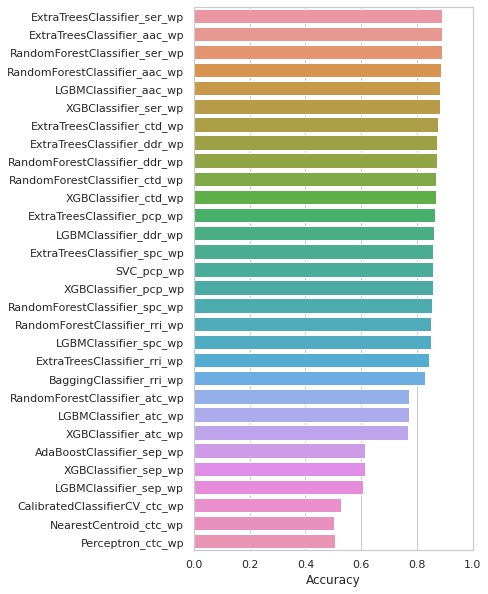

In [46]:
# Plot of Accuracy
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=results_all_fm.index+"_"+ results_all_fm.Dataset, x="Accuracy", 
                 data=results_all_fm)
ax.set(xlim=(0, 1))

[(0.0, 1.0)]

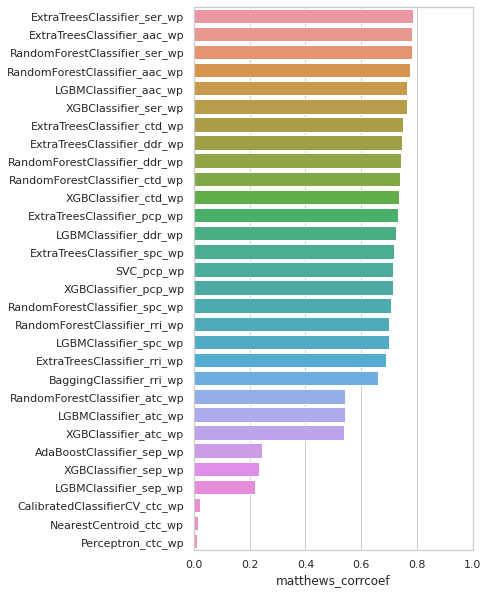

In [48]:
# Plot of MCC
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=results_all_fm.index+"_"+ results_all_fm.Dataset, 
                 x="matthews_corrcoef", data=results_all_fm)
ax.set(xlim=(0, 1))

---

# **Parameter tuning of the best ML models**

According to the previous analysis, the best models were **ExtraTreesClassifier** and **RandomForestClassifier** with ser_awp and aac_wp feature matrices.

I performed feature tuning with sklearn class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). This class allows to specify a grid with features for tuning, and also the number of folds if we want to use kfold cross validation for this process. So, I obtained the best set of features for the best 4 models in this way.

In [ ]:
# Build random forest model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

### **Apply the model to make predictions**

In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### **Model performance**

In [ ]:
feature_ACC['class']

0       positive
1       positive
2       positive
3       positive
4       positive
          ...   
7661    negative
7662    negative
7663    negative
7664    negative
7665    negative
Name: class, Length: 14609, dtype: object

In [ ]:
# Simplest and quickest way to obtain the model performance (Accuracy)
rf.score(X_test,y_test)

0.8898015058179329

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred)

0.8898015058179329

In [ ]:
# Matthew Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_test_pred)

0.782038687689927

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[1446,   87],
       [ 235, 1154]])

In [ ]:
# Classification report
from sklearn.metrics import classification_report

model_report = classification_report(y_train, y_train_pred, target_names=['positive','negative'])

f = open('model_report.txt','w')
f.writelines(model_report) 
f.close()

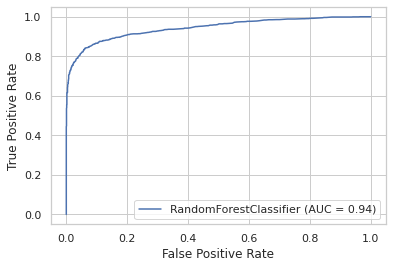

In [ ]:
# ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf, X_test, y_test)  
plt.show()

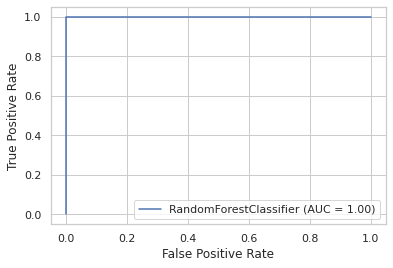

In [ ]:
plot_roc_curve(rf, X_train, y_train)  
plt.show()

### **Feature importance**

In [ ]:
# Display Dataframe of the dataset after feature selection (variance threshold)
X

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,0.00,0.00,7.69,0.00,15.38,15.38,0.00,23.08,7.69,15.38,0.00,7.69,0.00,0.00,0.00,7.69,0.00,0.00,0.00,0.00
1,15.38,0.00,0.00,0.00,7.69,7.69,0.00,15.38,0.00,30.77,0.00,7.69,0.00,0.00,0.00,15.38,0.00,0.00,0.00,0.00
2,15.38,0.00,0.00,0.00,15.38,7.69,0.00,0.00,15.38,38.46,0.00,0.00,0.00,0.00,0.00,7.69,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,5.88,0.00,0.00,5.88,5.88,0.00,29.41,0.00,11.76,11.76,11.76,0.00,0.00,5.88,5.88,0.00,5.88
4,0.00,0.00,7.69,0.00,7.69,7.69,0.00,7.69,0.00,23.08,0.00,0.00,7.69,7.69,7.69,0.00,15.38,7.69,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,7.78,5.56,10.00,8.89,4.44,4.44,1.11,10.00,6.67,12.22,2.22,3.33,1.11,3.33,2.22,8.89,2.22,4.44,0.00,1.11
7662,0.00,0.00,0.00,0.00,10.53,21.05,5.26,0.00,5.26,10.53,5.26,10.53,5.26,0.00,0.00,5.26,15.79,5.26,0.00,0.00
7663,0.00,10.00,0.00,5.00,5.00,10.00,5.00,0.00,10.00,5.00,5.00,20.00,0.00,0.00,0.00,0.00,15.00,5.00,0.00,5.00
7664,6.06,6.06,4.55,9.09,3.03,1.52,3.03,6.06,9.09,4.55,7.58,4.55,1.52,6.06,4.55,9.09,3.03,6.06,0.00,4.55


In [ ]:
# Retrieve feature importance from the RF model
importance = pd.Series(rf.feature_importances_, name = 'Gini')

# Retrieve feature names
feature_names = pd.Series(X.columns, name = 'Feature')

In [ ]:
# Combine feature names and Gini values into a Dataframe
df = pd.concat([feature_names, importance], axis=1, names=['Feature', 'Gini'])
df

,Feature,Gini
0,AAC_A,0.04
1,AAC_C,0.11
2,AAC_D,0.08
3,AAC_E,0.12
4,AAC_F,0.03
5,AAC_G,0.05
6,AAC_H,0.02
7,AAC_I,0.03
8,AAC_K,0.08
9,AAC_L,0.04


Text(0.5, 0, 'Feature Importance')

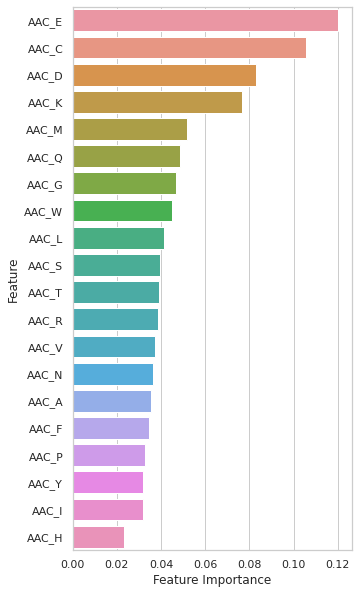

In [ ]:
# Plot of feature importance
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values('Gini', ascending=False)[:20] # Sort by Gini in descending order; Showing only the top 20 results

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'Gini', y = 'Feature', data = df_sorted)
plt.xlabel("Feature Importance")

---